In [1]:
import os
import matplotlib as mpl
import matplotlib.pylab as plt
import itertools
import csv , codecs
import glob
from PIL import Image
import numpy as np
import pandas as pd
import openpyxl
from openpyxl import Workbook
from openpyxl import load_workbook
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn
from sklearn import decomposition
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss



In [2]:
data_dir = "./EEG_data/"

## CSV 파일 생성 함수

In [3]:
def EEG_data_csv(data_dir):
    
    # Kinds of Power 입력
    file_list = os.listdir(data_dir)
    file_list.sort()
       
    global kinds_of_power
    kinds_of_power = "Relative"
    
    excel_dir = "./EEG_data" + '/' + kinds_of_power
    excel_list = sorted(glob.glob(excel_dir+'/[!~]*.xlsx'))
    
    # EEG_csv_data 디렉토리 생성
    csv_dir = "./EEG_csv_data"
    if not os.path.isdir(csv_dir):
        os.mkdir(csv_dir)
    
    Abs_dir ="./EEG_csv_data/Abs"
    Relative_dir = "./EEG_csv_data/Relative"
    
    if not os.path.isdir(Abs_dir):
        os.mkdir(Abs_dir)
    if not os.path.isdir(Relative_dir):
        os.mkdir(Relative_dir)
    
    book = Workbook()
    sheet = book.active
    
    # x축,y축 생성
    for i in range (1,21) :
        if i < 10 :
            sheet['A'+str(i+1)] = 'S0'+str(i)
        if i == 10 :
            sheet['A'+str(i+1)] = 'S'+str(10)
        if i > 10 :
            sheet['A'+str(i+1)] = 'S'+str(i)
            
    for j in range (0,12):
        for i in range(1,33):
            sheet.cell(row=1, column=160*j+i+1).value = 'ACh' + str(i)
            sheet.cell(row=1, column=160*j+i+33).value = 'BCh' + str(i)
            sheet.cell(row=1, column=160*j+i+65).value = 'DCh' + str(i)
            sheet.cell(row=1, column=160*j+i+97).value = 'GCh' + str(i)
            sheet.cell(row=1, column=160*j+i+129).value = 'TCh' + str(i)

    # 파일을 순차적으로 열어서 셀 영역을 복사
    # j: 엑셀 파일의 수, k: 각 엑셀 파일 당 시트의 수, n: task의 수, l: subject의 수, m: ch1-ch32

    for j in range(0,5):
        wb = openpyxl.load_workbook(excel_list[j], data_only=True)
        wb_sheet = wb.sheetnames
        for k in range(0,12):
            source = wb[wb_sheet[k]]
            for l in range(2, 22):
                for m in range(2, 34):
                    sheet.cell(row=l,column=160*k+m+32*j).value = source.cell(row=l,column=m).value

    # EEG_csv_data 디렉토리에 csv 파일로 저장
    if kinds_of_power == "Abs":
        with open(Abs_dir + str('/') +'Abs_Merged.csv', 'w', newline="") as f:
            c = csv.writer(f)
            for r in sheet.rows:
                c.writerow([cell.value for cell in r])
    elif kinds_of_power == "Relative":
        with open(Relative_dir + str('/') +'Relative_Merged.csv', 'w', newline="") as f:
            c = csv.writer(f)
            for r in sheet.rows:
                c.writerow([cell.value for cell in r])

## CSV 파일에서 Pandas dataframe으로 가져오는 함수

In [4]:
def data_setting(task, eye , respiratory):
    # 성재가 만든 파일 불러오는 경로 입력 및 데이터 프레임으로 불러올것 
    ##  Abs, Relative 설정은 여기서 변경하기기
    csv_name = "./EEG_csv_data/Abs/Abs_Merged.csv"
    data = pd.read_csv(csv_name) 
    data_column = data.columns
    
    
    # 1 back
    if task == 0 : 
        if respiratory == 0 :
            data = data[data_column[1:161]]
            # 1-back open eye mouse (alpha, beta, delta, gamma, theta   ch(32*5))
            
            
            
        elif respiratory == 1 :
            data = data[data_column[161:321]]
            # 1-back open eye nose (alpha, beta, delta, gamma, theta   ch(32*5))
        elif respiratory == 2 :
            data = data[data_column[321:481]]
            # 1-back open eye mouse o2 (alpha, beta, delta, gamma, theta   ch(32*5))
    # 2 back
    elif task == 1 : 
        if respiratory == 0 :
            data = data[data_column[481:641]]
            # 2-back open eye mouse (alpha, beta, delta, gamma, theta   ch(32*5))
        elif respiratory == 1 :
            data= data[data_column[641:801]]
            # 2-back open eye nose (alpha, beta, delta, gamma, theta   ch(32*5))
        elif respiratory == 2 :
            data = data[data_column[801:961]]
            # 2-back open eye mouse o2 (alpha, beta, delta, gamma, theta   ch(32*5))
    #resting
    elif task == 2 :
        ## eye ==0 close eye
        if eye == 0 :
            if respiratory == 0 :
                data = data[data_column[961:1121]]
                # resting open eye mouse (alpha, beta, delta, gamma, theta   ch(32*5))
            elif respiratory == 1 :
                data = data[data_column[1121:1281]]
                # resting open eye nose (alpha, beta, delta, gamma, theta   ch(32*5))
            elif respiratory == 2 :
                data = data[data_column[1281:1441]]
                # resting open eye mouse o2 (alpha, beta, delta, gamma, theta   ch(32*5))
        ## eye ==1 open eye
        if eye == 1 : 
            if respiratory == 0 :
                data = data[data_column[1441:1601]]
                # resting close eye mouse (alpha, beta, delta, gamma, theta   ch(32*5))
            elif respiratory == 1 :
                data = data[data_column[1601:1761]]
                # resting close eye nose (alpha, beta, delta, gamma, theta   ch(32*5))
            elif respiratory == 2 :
                data = data[data_column[1761:1921]]
                # resting close eye mouse o2 (alpha, beta, delta, gamma, theta   ch(32*5))

    
    
    
    
    return data
                
                
# column indexing task condition

### task list

In [5]:
wb = openpyxl.load_workbook(data_dir+ str('/') +'Relative'+str('/')+'R_Alpha.xlsx')
wb_sheet = wb.sheetnames
wb_sheet

['B1_M',
 'B1_N',
 'B1_O2',
 'B2_M',
 'B2_N',
 'B2_O2',
 'Rest_EC_M',
 'Rest_EC_N',
 'Rest_EC_O2',
 'Rest_EO_M',
 'Rest_EO_N',
 'Rest_EO_O2']

### Kinds of Power 입력

In [6]:
EEG_data_csv(data_dir)


### task 0 1 2 : 1-back  2-back  rest

### eye 0  1    : close eye     open eye

### respiratory 0 1 2 : mouse nose o2 



---

### dataset 만드는 함수

In [7]:
def dataset_csv():
    normalize_power = str(input("Relative, Abs :"))
    excel_dir = "./EEG_data" + '/' + normalize_power
    excel_list = sorted(glob.glob(excel_dir+'/[!~]*.xlsx'))
    
    subject = int(input("subject :"))
    

    book = Workbook()
    sheet = book.active
    sheet.cell(row=1, column=161).value = 'target'
 
    # x축 생성   
    for i in range(1,33):
        sheet.cell(row=1, column=i).value = 'ACh' + str(i)
        sheet.cell(row=1, column=i+32).value = 'BCh' + str(i)
        sheet.cell(row=1, column=i+64).value = 'DCh' + str(i)
        sheet.cell(row=1, column=i+96).value = 'GCh' + str(i)
        sheet.cell(row=1, column=i+128).value = 'TCh' + str(i)
        
    # 파일을 순차적으로 열어서 셀 영역을 복사
    for j in range(0,5):
        wb = openpyxl.load_workbook(excel_list[j], data_only=True)
        wb_sheet = wb.sheetnames
        for k in range(0,12):
            source = wb[wb_sheet[k]]
            for l in range(2, 22):
                for m in range(2, 34):
                    sheet.cell(row=20*k+l,column=32*j+m-1).value = source.cell(row=l,column=m).value
        

    with open('./dataset_eeg.csv', 'w', newline="") as f:
        c = csv.writer(f)
        for r in sheet.rows:
            c.writerow([cell.value for cell in r])
            
    df = pd.read_csv('./dataset_eeg.csv')
    df[df =='                      NaN'] =np.nan
    df = df.fillna(0.0).astype('float64')
    pd.options.mode.chained_assignment = None

    df["target"][0*subject:1*subject] = "010"
    df["target"][1*subject:2*subject] = "011"
    df["target"][2*subject:3*subject] = "012"

    df["target"][3*subject:4*subject] = "110"
    df["target"][4*subject:5*subject] = "111"
    df["target"][5*subject:6*subject] = "112"

    df["target"][6*subject:7*subject] = "200"
    df["target"][7*subject:8*subject] = "201"
    df["target"][8*subject:9*subject] = "202"

    df["target"][9*subject:10*subject] = "210"
    df["target"][10*subject:11*subject] = "211"
    df["target"][11*subject:12*subject] = "212"
    df.astype('float64')
    df.to_csv('./dataset_eeg.csv')
    
    return df
            


In [11]:
eeg_data = dataset_csv()

Relative, Abs : Relative
subject : 20


In [12]:
eeg_data

,ACh1,ACh2,ACh3,ACh4,ACh5,ACh6,ACh7,ACh8,ACh9,ACh10,...,TCh24,TCh25,TCh26,TCh27,TCh28,TCh29,TCh30,TCh31,TCh32,target
0,4.512153,2.236848,16.237565,8.485316,23.868040,8.095887,61.092520,63.790479,68.686679,69.925212,...,8.735276,0.828638,1.010004,1.778969,6.435780,14.978180,11.507832,11.162954,9.491918,010
1,4.539769,4.310226,4.959007,3.965357,7.222414,5.466902,16.751086,19.945360,30.425709,24.128985,...,18.794290,9.741533,7.106003,10.521237,8.559514,18.069939,15.457455,22.764836,22.393518,010
2,9.876811,9.070304,3.572186,4.272411,12.559673,19.156709,26.778865,17.134912,53.187562,49.574373,...,11.408656,6.724140,8.721257,10.193054,2.678986,11.522934,11.118133,11.282202,10.760432,010
3,4.224107,6.190282,8.670873,8.869054,25.241644,20.749929,40.968150,43.190059,42.509827,41.379676,...,10.493111,4.743475,5.994422,2.769252,5.845854,11.149340,12.461344,12.748985,11.845096,010
4,18.441049,19.286110,8.901129,12.888736,7.272771,15.879294,23.182914,38.046045,29.140603,32.524267,...,14.825606,16.428830,15.406232,16.088470,17.454960,18.750681,17.095190,13.764769,13.443134,010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,9.377716,6.913374,5.995995,4.562073,6.141009,6.275420,17.190073,19.530794,29.798448,27.170256,...,5.781882,11.865520,10.328138,10.171290,11.796915,15.583215,16.539841,15.194092,14.108681,212
236,11.906533,10.057115,11.180124,11.478218,14.621087,16.359638,26.560596,24.297633,30.679741,26.798845,...,16.024479,6.548399,6.806564,10.569691,14.455136,15.406702,16.142647,14.712165,14.551317,212
237,10.335814,8.589677,13.796878,13.048695,25.629270,24.416874,33.204969,34.318945,29.184918,28.485295,...,24.964200,19.061720,18.617480,16.023406,20.075270,26.804320,25.657373,24.098649,19.401579,212
238,14.781336,13.040448,5.557476,4.101700,19.404795,10.489655,27.480708,24.014191,32.643752,30.794355,...,20.821745,9.054677,14.631369,11.264431,17.292341,19.074393,22.937862,23.429094,12.989213,212


In [13]:
from sklearn.ensemble import RandomForestClassifier
X = eeg_data.iloc[:,0:-1]
X1=np.array(X)
Y = eeg_data['target']
Y1= np.array(Y)


X_train, X_test, y_train, y_test = train_test_split(X1, Y1, random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
for name, score in zip(X.columns.tolist(), rnd_clf.feature_importances_):
    print(name, score)

ACh1 0.007587008417389649
ACh2 0.006152328393046351
ACh3 0.007018916110587065
ACh4 0.0059285172498349985
ACh5 0.005157037900518623
ACh6 0.00579162297296112
ACh7 0.006013415786220678
ACh8 0.006593112809956641
ACh9 0.009029062058432543
ACh10 0.008616784800142798
ACh11 0.006244665798661268
ACh12 0.006227855505849455
ACh13 0.007221147042214655
ACh14 0.005768580241686409
ACh15 0.0053891525570906726
ACh16 0.00522237589741898
ACh17 0.0065570466817298475
ACh18 0.0
ACh19 0.005722865960595451
ACh20 0.007588661716306719
ACh21 0.005161212297639085
ACh22 0.005844640799209327
ACh23 0.005477401497389924
ACh24 0.005007400735563717
ACh25 0.006112367231673394
ACh26 0.005482229431378669
ACh27 0.006714468352178618
ACh28 0.006608903935856279
ACh29 0.006510443049839862
ACh30 0.005723890570008527
ACh31 0.006989312385059141
ACh32 0.0051499842494916945
BCh1 0.007423557639470103
BCh2 0.008373374676955987
BCh3 0.006691755227578509
BCh4 0.006802654423096436
BCh5 0.007102791105380151
BCh6 0.006984592552588529
BCh7

## **train set에 관한 feature 160의 variances 계산**

In [14]:

from sklearn.feature_selection import VarianceThreshold

X_train, X_test, y_train, y_test = train_test_split(X1, Y1, random_state=42)

thresholder=VarianceThreshold()

variances=thresholder.fit(X_train)

d1_train=dict(zip(X.columns.tolist(), list(variances.variances_)))
d2_train=dict(zip(X.columns.tolist(), list(rnd_clf.feature_importances_)))

for name, variance, importance in zip(X.columns.tolist(), d1_train.values(), d2_train.values() ):
    print(name, variance, importance)

ACh1 24.9742856955811 0.007587008417389649
ACh2 28.494850761797917 0.006152328393046351
ACh3 29.136138202772436 0.007018916110587065
ACh4 29.220829872925744 0.0059285172498349985
ACh5 46.702028656619184 0.005157037900518623
ACh6 41.84621867765508 0.00579162297296112
ACh7 68.1628038064602 0.006013415786220678
ACh8 73.23761846346146 0.006593112809956641
ACh9 73.49989886881383 0.009029062058432543
ACh10 77.4780650005016 0.008616784800142798
ACh11 35.559490246336196 0.006244665798661268
ACh12 33.717913934066786 0.006227855505849455
ACh13 46.63048357284951 0.007221147042214655
ACh14 51.30137928883607 0.005768580241686409
ACh15 65.22511440757512 0.0053891525570906726
ACh16 69.3518316795425 0.00522237589741898
ACh17 41.32121977982774 0.0065570466817298475
ACh18 0.0 0.0
ACh19 57.342975191284935 0.005722865960595451
ACh20 77.96187387432465 0.007588661716306719
ACh21 35.531973064443754 0.005161212297639085
ACh22 37.39653776587193 0.005844640799209327
ACh23 61.46535640790887 0.005477401497389924


In [15]:
def f2(x):
    return x[1]

sorted_d1_train = dict(sorted(d1_train.items(),key=f2,reverse=True))
sorted_d2_train = dict(sorted(d2_train.items(),key=f2,reverse=True))


In [16]:
df=pd.DataFrame()

#variance가 높은 순으로 ch, importance 정렬
df['varinace']=sorted_d1_train.values()
df.index=sorted_d1_train.keys()

channel=list(sorted_d1_train.keys())
importance_list=[]

for i in range(0,160):
    importance_list.append(sorted_d2_train.get(channel[i]))

df['importance']=importance_list

print(df)

df.to_csv("./train_variance_importance2.csv")

        varinace  importance
DCh1   97.555023    0.006261
DCh22  88.801422    0.006390
DCh12  85.377765    0.006207
DCh25  84.045844    0.006417
DCh6   81.596010    0.006263
...          ...         ...
ACh18   0.000000    0.000000
BCh18   0.000000    0.000000
DCh18   0.000000    0.000000
GCh18   0.000000    0.000000
TCh18   0.000000    0.000000

[160 rows x 2 columns]


In [55]:
df.describe()

,variance,importance
count,160.000000,160.000000
mean,40.457232,0.006250
std,23.288306,0.001655
min,0.000000,0.000000
25%,27.390278,0.005501
50%,35.873017,0.006218
75%,57.642376,0.007042
max,97.555023,0.010868


## feature importance의 variance 상관관계

            variance  importance
variance    1.000000    0.053026
importance  0.053026    1.000000


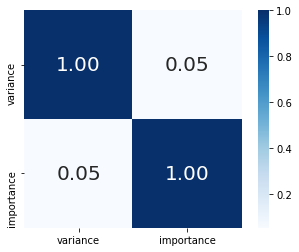

In [17]:
lst=np.array(range(320),dtype=np.float).reshape((2,160))

lst[0]=list(sorted_d1_train.values())
lst[1]=importance_list
 
df=pd.DataFrame({"variance":list(sorted_d1_train.values()),"importance":importance_list})
corr=df.corr(method='pearson')
print(corr)

import matplotlib.pyplot as plt 
import seaborn as sns

df_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 20}, fmt = '.2f', square = True, cmap = 'Blues')

---

무작위로 선택된 수천 명의 사람에게 복잡한 질문을 하고 대답을 모으면 많은 경우 전문가의 답보다 이렇게 모은 답이 낫습니다. 

이를 **대중의 지혜(wisdom of crowd)** 라고 합니다.



이와 비슷하게 일련의 예측기로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있습니다. 

일련의 예측기를 **앙상블(ensemble)** 이라고 부릅니다. 


Decision tree의 ensemble을 **Random Forest**라고 합니다. 

---



###    1. 160개의 feature 중에서 Randomforest classification을 통해 Feature importance로 상위 몇 개의 feature를 선택합니다.


###    2. 선택한 상위 feature 들을 Linear Discriminant Analysis(LDA)를 적용하여 차원 축소를 진행합니다.


###    3. 줄어든 Dimension 상에서 RandomForest와 같은 Enseble Classification을 진행합니다. 


* Linear Discriminant Analysis (LDA)은 훈련과정에서 클래스 사이를 가장 잘 구분하는 축을 학습합니다. 이 축은 데이터가 투영되는 hyperplane을 정의하는데 사용할 수 있습니다.
이 알고리즘의 장점은 projection을 통해 가능한 한 클래스를 멀리 떨어지게 유지하므로 SVM과 같은 다른 classification 알고리즘을 적용하기 전에 차원을 축소시키는데 좋습니다

# Random forest classification을 사용하여 feature importance를 알아냅니다.



* **RandomForest feature importance는 DecisionTree importance를 feature 별로 평균화해서 feature importance를 구함**

    - 최종적으로 feature importance의 합이 1이 되도록 정규화함
    
    - DecisionTree에서 node 하나의 importance는 다음과 같이 계산함
        + 
        $$
        \frac{\mathbf{n}_p \times \mathbf{I}_p - (\mathbf{n}_l \times \mathbf{I}_l + \mathbf{n}_r \times \mathbf{I}_r )}{\mathbf{n}}
        $$
        + $\mathbf{n}_p$와$\mathbf{I}_p$는 각각 상위 node의 sample개수와 불순도
        + $\mathbf{n}_l$와 $\mathbf{I}_l$는 왼쪽 node, $\mathbf{n}_r$와 $\mathbf{I}_r$는 오른쪽 node의 sample개수와 불순도

In [18]:
from sklearn.ensemble import RandomForestClassifier

# channel은 feature 이름과 feature importance를 같이 담고 있는 list
channel = []
# choice된 top feature list
choice_feature =[]


#######################################################################
#   Random forest classification을 사용하여 feature importance를 얻어냄#      
#######################################################################
X = eeg_data.iloc[:,0:-1]
Y = eeg_data['target']
X1 = np.array(eeg_data.iloc[:,0:-1])
Y1 = np.array(eeg_data['target'])
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [19]:
# feature importance를 얻어내기 위해 사용한 Randomforest의 정확도
rnd_clf.score(X_test,y_test)

0.05

### 얻어낸 feature importance를 이용하여 feature importances가 높은 Channel을 선택합니다.



print("1~155, (feature importance, 'ACh18,BCh18,DCh18,GCh18,TCh18'=0 )")
aa= int(input("top feature of number : " ))
feature_list= list(zip(X.columns.tolist(),rnd_clf.feature_importances_))
feature_dict= dict(zip(X.columns.tolist(),rnd_clf.feature_importances_))
sorted_feature = sorted(feature_dict.values(), reverse=True)
top_feature = sorted_feature[0:aa]


for i in range(len(feature_list)):
    for j in range(len(top_feature)):
        if feature_list[i][1] == top_feature[j]:
            channel.append(feature_list[i])
        else:
            continue
            
for i in range(len(channel)):
    choice_feature.append(channel[i][0])
    
#print(choice_feature)
choice_feature_df = eeg_data[choice_feature]
choice_feature_df.shape


# Channel(feature)을 feature importance 내림차순으로 정렬합니다.

In [20]:
important = rnd_clf.feature_importances_
channel_important =important[0:32]+important[32:64]+important[64:96]+important[96:128]+important[128:160]

channel_list = []
for i in range(1,len(channel_important)+1):
    channel_list.append("Ch"+str(i))
channel_list

feature_list2= list(zip(channel_list,channel_important))
feature_list2

[('Ch1', 0.03489035224847585),
 ('Ch2', 0.038242839513376176),
 ('Ch3', 0.03677712435293869),
 ('Ch4', 0.03819682592920495),
 ('Ch5', 0.03390268526106585),
 ('Ch6', 0.035408378887680475),
 ('Ch7', 0.02753411947861204),
 ('Ch8', 0.030664719363380968),
 ('Ch9', 0.032596507247777254),
 ('Ch10', 0.037350127066646914),
 ('Ch11', 0.030410779263039235),
 ('Ch12', 0.025985618299923928),
 ('Ch13', 0.032598207081357175),
 ('Ch14', 0.03359165032059278),
 ('Ch15', 0.029575586925487354),
 ('Ch16', 0.026187644509038044),
 ('Ch17', 0.033384363130639354),
 ('Ch18', 0.0),
 ('Ch19', 0.02498439854684391),
 ('Ch20', 0.03290512798782788),
 ('Ch21', 0.03176182998008998),
 ('Ch22', 0.029918302733440122),
 ('Ch23', 0.029135865956550815),
 ('Ch24', 0.030241990858975252),
 ('Ch25', 0.029793875283570838),
 ('Ch26', 0.03611987385231999),
 ('Ch27', 0.03609429042794179),
 ('Ch28', 0.034257896357009744),
 ('Ch29', 0.0341338445914672),
 ('Ch30', 0.033235373273846625),
 ('Ch31', 0.029125918028880524),
 ('Ch32', 0.0309

In [21]:
sorted_channel2 = []
reverse_channel = []
sorting_important=[]
for i in range(len(feature_list2)):
    reverse_channel.append(list(reversed(feature_list2[i])))

    

sorted_channel2 = sorted(reverse_channel,reverse=True)

for i in range(len(feature_list2)):
    sorting_important.append(list(reversed(sorted_channel2[i])))
    
sorting_important

[['Ch2', 0.038242839513376176],
 ['Ch4', 0.03819682592920495],
 ['Ch10', 0.037350127066646914],
 ['Ch3', 0.03677712435293869],
 ['Ch26', 0.03611987385231999],
 ['Ch27', 0.03609429042794179],
 ['Ch6', 0.035408378887680475],
 ['Ch1', 0.03489035224847585],
 ['Ch28', 0.034257896357009744],
 ['Ch29', 0.0341338445914672],
 ['Ch5', 0.03390268526106585],
 ['Ch14', 0.03359165032059278],
 ['Ch17', 0.033384363130639354],
 ['Ch30', 0.033235373273846625],
 ['Ch20', 0.03290512798782788],
 ['Ch13', 0.032598207081357175],
 ['Ch9', 0.032596507247777254],
 ['Ch21', 0.03176182998008998],
 ['Ch32', 0.030993883241998317],
 ['Ch8', 0.030664719363380968],
 ['Ch11', 0.030410779263039235],
 ['Ch24', 0.030241990858975252],
 ['Ch22', 0.029918302733440122],
 ['Ch25', 0.029793875283570838],
 ['Ch15', 0.029575586925487354],
 ['Ch23', 0.029135865956550815],
 ['Ch31', 0.029125918028880524],
 ['Ch7', 0.02753411947861204],
 ['Ch16', 0.026187644509038044],
 ['Ch12', 0.025985618299923928],
 ['Ch19', 0.02498439854684391],

In [22]:
def channel_select ():
    
    print( "channel importance")
    print("channel num :1 ~ 32")
    
    #val = []
    
    for i in range(len(sorting_important)):
        #val.append(sorting_important[i][1])
        print( sorting_important[i])
        
    #print(sum(val))
    channel = int(input("selecting feature number : "))
    select_channel=sorting_important[0:channel]
    
    columns_name = []
    for i in range(len(select_channel)):
        columns_name.append("A"+select_channel[i][0])
        columns_name.append("B"+select_channel[i][0])
        columns_name.append("D"+select_channel[i][0])
        columns_name.append("G"+select_channel[i][0])
        columns_name.append("T"+select_channel[i][0])
    columns_name = sorted(columns_name)
    df = eeg_data[columns_name]
    return df

In [24]:
data = channel_select()

channel importance
channel num :1 ~ 32
['Ch2', 0.038242839513376176]
['Ch4', 0.03819682592920495]
['Ch10', 0.037350127066646914]
['Ch3', 0.03677712435293869]
['Ch26', 0.03611987385231999]
['Ch27', 0.03609429042794179]
['Ch6', 0.035408378887680475]
['Ch1', 0.03489035224847585]
['Ch28', 0.034257896357009744]
['Ch29', 0.0341338445914672]
['Ch5', 0.03390268526106585]
['Ch14', 0.03359165032059278]
['Ch17', 0.033384363130639354]
['Ch30', 0.033235373273846625]
['Ch20', 0.03290512798782788]
['Ch13', 0.032598207081357175]
['Ch9', 0.032596507247777254]
['Ch21', 0.03176182998008998]
['Ch32', 0.030993883241998317]
['Ch8', 0.030664719363380968]
['Ch11', 0.030410779263039235]
['Ch24', 0.030241990858975252]
['Ch22', 0.029918302733440122]
['Ch25', 0.029793875283570838]
['Ch15', 0.029575586925487354]
['Ch23', 0.029135865956550815]
['Ch31', 0.029125918028880524]
['Ch7', 0.02753411947861204]
['Ch16', 0.026187644509038044]
['Ch12', 0.025985618299923928]
['Ch19', 0.02498439854684391]
['Ch18', 0.0]


selecting feature number :  160


In [25]:
data

,ACh1,ACh10,ACh11,ACh12,ACh13,ACh14,ACh15,ACh16,ACh17,ACh18,...,TCh3,TCh30,TCh31,TCh32,TCh4,TCh5,TCh6,TCh7,TCh8,TCh9
0,4.512153,69.925212,11.263455,13.204760,21.564257,40.455822,61.780233,63.703514,5.997749,0.0,...,5.673796,11.507832,11.162954,9.491918,3.598896,5.941709,1.656927,9.760826,8.661677,7.235869
1,4.539769,24.128985,5.103897,4.117744,11.495993,17.199812,14.364287,15.798085,5.016286,0.0,...,16.966718,15.457455,22.764836,22.393518,13.196881,17.423661,13.353375,22.059684,19.089995,14.375457
2,9.876811,49.574373,4.760022,8.141746,17.605909,27.498355,30.822483,33.346680,9.764571,0.0,...,5.341504,11.118133,11.282202,10.760432,5.847675,13.561016,13.076631,14.896952,5.983786,7.681887
3,4.224107,41.379676,10.889194,13.341544,25.956096,31.839421,40.649491,41.080129,12.167993,0.0,...,5.495164,12.461344,12.748985,11.845096,4.677333,11.372016,7.316882,12.464392,10.458767,10.555316
4,18.441049,32.524267,15.373357,12.630065,13.485333,24.469171,27.148828,39.845233,16.420239,0.0,...,11.863384,17.095190,13.764769,13.443134,15.429647,7.212496,13.094720,18.202155,14.269946,14.342443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,9.377716,27.170256,7.786197,7.483846,8.699358,9.498228,19.238846,21.895583,9.291614,0.0,...,14.636472,16.539841,15.194092,14.108681,11.146622,11.763126,10.808589,17.442276,15.556296,11.719461
236,11.906533,26.798845,8.607284,8.793221,14.757784,17.676136,29.588759,26.990570,10.649820,0.0,...,15.628756,16.142647,14.712165,14.551317,14.200540,14.729774,15.432356,19.029062,17.546902,15.830547
237,10.335814,28.485295,18.912526,18.150611,30.372339,37.062017,34.595179,38.866391,21.816493,0.0,...,23.128340,25.657373,24.098649,19.401579,20.523636,32.627739,24.731760,30.105868,24.842073,23.474267
238,14.781336,30.794355,9.252369,9.115270,15.796576,11.005532,32.923175,29.777934,13.468513,0.0,...,10.261000,22.937862,23.429094,12.989213,8.635734,21.508771,14.345015,26.358745,22.176200,18.592818


In [26]:
X2 = np.array(data.iloc[:])

In [27]:
Y2= np.array(Y)

In [28]:
X2.shape

(240, 160)

In [29]:
Y2.shape

(240,)

### LDA 적용후 k-fold validation으로 RandomForest진행

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(X2,Y2)
all_scores = []

rnd_clf = RandomForestClassifier(n_estimators=100)
lda = LinearDiscriminantAnalysis(n_components=None)

lda = LinearDiscriminantAnalysis(n_components=11)
lda.fit(X2,Y2)

X_reduced_lda = lda.transform(X2)


for train_index, test_index in skf.split(X_reduced_lda,Y2):
    rnd_clf.fit(X_reduced_lda[train_index], Y2[train_index])
    val_mae = rnd_clf.score(X_reduced_lda[test_index],Y2[test_index])
    all_scores.append(val_mae)
    
print(all_scores)

[0.6666666666666666, 0.875, 0.875, 0.7083333333333334, 0.9166666666666666, 0.875, 0.7083333333333334, 0.9166666666666666, 0.875, 0.9166666666666666]


In [31]:
print(np.mean(all_scores)*100,"%")

83.33333333333333 %


In [32]:
def draw_graph ():
    result = []
    feature_num = [] 
    for i in range(1,33):
        select_channel=sorting_important[0:i]
        columns_name = []
        for j in range(len(select_channel)):
            columns_name.append("A"+select_channel[j][0])
            columns_name.append("B"+select_channel[j][0])
            columns_name.append("D"+select_channel[j][0])
            columns_name.append("G"+select_channel[j][0])
            columns_name.append("T"+select_channel[j][0])
        columns_name = sorted(columns_name)
        df = eeg_data[columns_name]
        X2 = np.array(df.iloc[:])
        Y2= np.array(Y)
        skf = StratifiedKFold(n_splits=10, shuffle=True)
        skf.get_n_splits(X2,Y2)
        all_scores = []
        rnd_clf = RandomForestClassifier(n_estimators=100)
        lda = LinearDiscriminantAnalysis(n_components=11)
        lda.fit(X2,Y2)
        X_reduced_lda = lda.transform(X2)
        for train_index, test_index in skf.split(X_reduced_lda,Y2):
            rnd_clf.fit(X_reduced_lda[train_index], Y2[train_index])
            val_mae = rnd_clf.score(X_reduced_lda[test_index],Y2[test_index])
            all_scores.append(val_mae)
        result.append(np.mean(all_scores)*100)
    for k in range (5,165,5):
        feature_num.append(k)
        
    plt.figure(figsize=(11,4))
    plt.title("LDA k-fold validation RandomForest ", fontsize=14)
    plt.xlabel("Top_feature_number", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.xlim(0,165)
    plt.ylim(0,100)
    plt.plot(feature_num,result)
    plt.grid(which='both')
    plt.show()    
    return list(zip(feature_num, result))

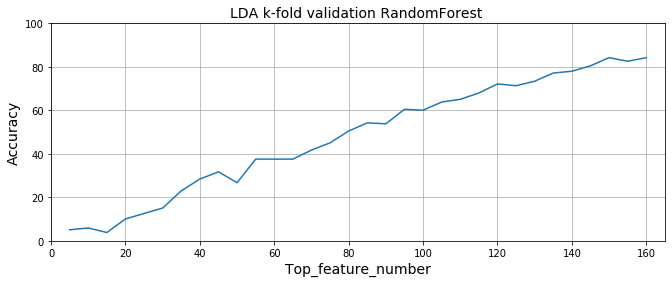

In [33]:
result = draw_graph()

# Channel 개수 별  Accuracy 정도 

In [34]:
result

[(5, 5.0),
 (10, 5.833333333333333),
 (15, 3.75),
 (20, 10.0),
 (25, 12.5),
 (30, 14.999999999999996),
 (35, 22.916666666666664),
 (40, 28.333333333333332),
 (45, 31.66666666666667),
 (50, 26.666666666666668),
 (55, 37.49999999999999),
 (60, 37.5),
 (65, 37.5),
 (70, 41.66666666666667),
 (75, 45.0),
 (80, 50.416666666666664),
 (85, 54.166666666666664),
 (90, 53.75),
 (95, 60.41666666666667),
 (100, 60.0),
 (105, 63.74999999999999),
 (110, 65.0),
 (115, 67.91666666666667),
 (120, 72.08333333333333),
 (125, 71.25),
 (130, 73.33333333333334),
 (135, 77.08333333333334),
 (140, 77.91666666666666),
 (145, 80.41666666666666),
 (150, 84.16666666666666),
 (155, 82.5),
 (160, 84.16666666666669)]

# 채널별 feature가 각 주파수 별로 important가 몇인지 dataframe으로 정리하기 

In [35]:
channel_important =important[0:32]+important[32:64]+important[64:96]+important[96:128]+important[128:160]

alpha =[]
beta = []
delta = []
gamma = []
theta = []
total = []
value =[]
value1 =[]
max_value =[]

for i in range(len(important[0:32])):
    alpha.append(important[0:32][i])
    beta.append(important[32:64][i])
    delta.append(important[64:96][i])
    gamma.append(important[96:128][i])
    theta.append(important[128:160][i])
    total.append(channel_important[i])


for i in range(len(channel_list)):
    value.append(list(zip([total[i],alpha[i],beta[i],delta[i],gamma[i],theta[i]])))
    value1.append(list(zip([alpha[i],beta[i],delta[i],gamma[i],theta[i]])))

for i in range(len(channel_list)):
    max_value.append(max(np.array(value1).reshape(32,5).tolist()[i]))

    
value = np.array(value).reshape(32,6).tolist()    
rank_data = list(zip(channel_list,value))
channel_df = pd.DataFrame(value,index=channel_list, columns=["total","alpha","beta","delta","gamma","theta"])
channel_df["Rank"] = channel_df["total"].rank(ascending=False)
channel_df["max_value"] = max_value


channel_df.sort_values("total",ascending=False ,inplace = True)
channel_df.name = ("Feature importance")
a = []
for i in range(len(channel_list)):
    if channel_df[channel_df.columns[1]][channel_df.index[i]] == channel_df["max_value"][channel_df.index[i]]:
        a.append("alpha")
    elif channel_df[channel_df.columns[2]][channel_df.index[i]] == channel_df["max_value"][channel_df.index[i]]:
        a.append("beta")
    elif channel_df[channel_df.columns[3]][channel_df.index[i]] == channel_df["max_value"][channel_df.index[i]]:
        a.append("delta")
    elif channel_df[channel_df.columns[4]][channel_df.index[i]] == channel_df["max_value"][channel_df.index[i]]:
        a.append("gamma")
    elif channel_df[channel_df.columns[5]][channel_df.index[i]] == channel_df["max_value"][channel_df.index[i]]:
        a.append("theata")
channel_df["max_channel"] = a


print(channel_df.name)
channel_df

Feature importance


,total,alpha,beta,delta,gamma,theta,Rank,max_value,max_channel
Ch2,0.038243,0.008152,0.008358,0.004603,0.011720,0.005410,1.0,0.011720,gamma
Ch4,0.038197,0.008456,0.006796,0.009758,0.006961,0.006226,2.0,0.009758,delta
Ch10,0.037350,0.011166,0.005250,0.009180,0.006761,0.004992,3.0,0.011166,alpha
Ch3,0.036777,0.007024,0.007805,0.006325,0.009200,0.006424,4.0,0.009200,gamma
Ch26,0.036120,0.006452,0.007452,0.004147,0.011115,0.006954,5.0,0.011115,gamma
Ch27,0.036094,0.007773,0.006016,0.006489,0.009762,0.006054,6.0,0.009762,gamma
Ch6,0.035408,0.005130,0.008045,0.008019,0.007489,0.006726,7.0,0.008045,beta
Ch1,0.034890,0.008599,0.008034,0.005395,0.005062,0.007799,8.0,0.008599,alpha
Ch28,0.034258,0.006928,0.006040,0.006560,0.008973,0.005756,9.0,0.008973,gamma
Ch29,0.034134,0.007338,0.005463,0.006726,0.009397,0.005210,10.0,0.009397,gamma


# Nose, Mouse로 training 시키고 O2가 무엇으로 분류되는지 확인하기


### task 0 1 2 : 1-back  2-back  rest

### eye 0  1    : close eye     open eye

### respiratory 0 1 2 : mouse nose o2 



In [36]:
def dataset_csv_3():
    normalize_power = str(input("Relative, Abs :"))
    excel_dir = "./EEG_data" + '/' + normalize_power
    excel_list = sorted(glob.glob(excel_dir+'/[!~]*.xlsx'))
    
    subject = int(input("subject :"))
    book = Workbook()
    sheet = book.active
    sheet.cell(row=1, column=161).value = 'target'
 
    # x축 생성   
    for i in range(1,33):
        sheet.cell(row=1, column=i).value = 'ACh' + str(i)
        sheet.cell(row=1, column=i+32).value = 'BCh' + str(i)
        sheet.cell(row=1, column=i+64).value = 'DCh' + str(i)
        sheet.cell(row=1, column=i+96).value = 'GCh' + str(i)
        sheet.cell(row=1, column=i+128).value = 'TCh' + str(i)
        
    # 파일을 순차적으로 열어서 셀 영역을 복사
    for j in range(0,5):
        wb = openpyxl.load_workbook(excel_list[j], data_only=True)
        wb_sheet = wb.sheetnames
        for k in range(0,12):
            source = wb[wb_sheet[k]]
            for l in range(2, 22):
                for m in range(2, 34):
                    sheet.cell(row=20*k+l,column=32*j+m-1).value = source.cell(row=l,column=m).value
        

    with open('./dataset_eeg_3.csv', 'w', newline="") as f:
        c = csv.writer(f)
        for r in sheet.rows:
            c.writerow([cell.value for cell in r])
            
    df = pd.read_csv('./dataset_eeg_3.csv')
    df[df =='                      NaN'] =np.nan
    df = df.fillna(0.0).astype('float64')
    pd.options.mode.chained_assignment = None

    df["target"][0*subject:1*subject] = "0"
    df["target"][1*subject:2*subject] = "1"
    df["target"][2*subject:3*subject] = "2"

    df["target"][3*subject:4*subject] = "0"
    df["target"][4*subject:5*subject] = "1"
    df["target"][5*subject:6*subject] = "2"

    df["target"][6*subject:7*subject] = "0"
    df["target"][7*subject:8*subject] = "1"
    df["target"][8*subject:9*subject] = "2"

    df["target"][9*subject:10*subject] = "0"
    df["target"][10*subject:11*subject] = "1"
    df["target"][11*subject:12*subject] = "2"
    df.astype('float64')
    df.to_csv('./dataset_eeg_3.csv')
    
    return df
            


In [37]:
eeg_data_3 = dataset_csv_3()

Relative, Abs : Relative
subject : 20


C:\Users\whbom\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [44]:
state={}

state["1back_mouse"]=eeg_data_3.iloc[0:20]
state["1back_nose"]=eeg_data_3.iloc[20:40]
state["1back_O2"]=eeg_data_3.iloc[40:60]

state["2back_mouse"]=eeg_data_3.iloc[60:80]
state["2back_nose"]=eeg_data_3.iloc[80:100]
state["2back_O2"]=eeg_data_3.iloc[100:120]

state["close_rest_mouse"]=eeg_data_3.iloc[120:140]
state["close_rest_nose"]=eeg_data_3.iloc[140:160]
state["close_rest_O2"]=eeg_data_3.iloc[160:180]

state["open_rest_mouse"]=eeg_data_3.iloc[180:200]
state["open_rest_nose"]=eeg_data_3.iloc[200:220]
state["open_rest_O2"]=eeg_data_3.iloc[220:2400]


In [52]:
ds_train = {}
ds_test = {}


ds_train={"1back_mouse":state["1back_mouse"], 
       "1back_nose":state["1back_nose"],
       "1back_O2":state["1back_O2"],
       "1back_m_n":state["1back_mouse"].append(state["1back_nose"]),
       "1back":state["1back_mouse"].append(state["1back_nose"]).append(state["1back_O2"]),
       
                                               
       "2back_mouse":state["2back_mouse"],
       "2back_nose":state["2back_nose"],
       "2back_O2":state["2back_O2"],
       "2back_m_n":state["2back_mouse"].append(state["2back_nose"]),
       "2back":state["2back_mouse"].append(state["2back_nose"]).append(state["2back_O2"]),
       
       "close_rest_mouse":state["close_rest_mouse"], 
       "close_rest_nose":state["close_rest_nose"],
       "close_rest_O2":state["close_rest_O2"],
       "close_rest_m_n":state["close_rest_mouse"].append(state["close_rest_nose"]),
       "close_rest":state["close_rest_mouse"].append(state["close_rest_nose"]).append(state["close_rest_O2"]),
       
       "open_rest_mouse":state["open_rest_mouse"],
       "open_rest_nose":state["open_rest_nose"],
       "open_rest_O2":state["open_rest_O2"],
       "open_rest_m_n":state["open_rest_mouse"].append(state["open_rest_nose"]),
       "open_rest":state["open_rest_mouse"].append(state["open_rest_nose"]).append(state["open_rest_O2"]),
       
       
       "total_mouse" : state["1back_mouse"].append(state["2back_mouse"]).append(state["close_rest_mouse"]).append(state["open_rest_mouse"]),
       "total_nose" : state["1back_nose"].append(state["2back_nose"]).append(state["close_rest_nose"]).append(state["open_rest_nose"]),
       "total_O2" : state["1back_O2"].append(state["2back_O2"]).append(state["close_rest_O2"]).append(state["open_rest_O2"]),
       "total_m_n": state["1back_mouse"].append(state["1back_nose"]).append(state["2back_mouse"]).append(state["2back_nose"]).append(state["close_rest_mouse"]).append(state["close_rest_nose"]).append(state["open_rest_mouse"]).append(state["open_rest_nose"]),
       "total": state["1back_mouse"].append(state["1back_nose"]).append(state["1back_O2"]).append(state["2back_mouse"]).append(state["2back_nose"]).append(state["2back_O2"]).append(state["close_rest_mouse"]).append(state["close_rest_nose"]).append(state["close_rest_O2"]).append(state["open_rest_mouse"]).append(state["open_rest_nose"]).append(state["open_rest_O2"])
       
       
      }

ds_test = {"1back_mouse":state["1back_mouse"], 
       "1back_nose":state["1back_nose"],
       "1back_O2":state["1back_O2"],
       "1back_m_n":state["1back_mouse"].append(state["1back_nose"]),
       "1back":state["1back_mouse"].append(state["1back_nose"]).append(state["1back_O2"]),
       
                                               
       "2back_mouse":state["2back_mouse"],
       "2back_nose":state["2back_nose"],
       "2back_O2":state["2back_O2"],
       "2back_m_n":state["2back_mouse"].append(state["2back_nose"]),
       "2back":state["2back_mouse"].append(state["2back_nose"]).append(state["2back_O2"]),
       
       "close_rest_mouse":state["close_rest_mouse"], 
       "close_rest_nose":state["close_rest_nose"],
       "close_rest_O2":state["close_rest_O2"],
       "close_rest_m_n":state["close_rest_mouse"].append(state["close_rest_nose"]),
       "close_rest":state["close_rest_mouse"].append(state["close_rest_nose"]).append(state["close_rest_O2"]),
       
       "open_rest_mouse":state["open_rest_mouse"],
       "open_rest_nose":state["open_rest_nose"],
       "open_rest_O2":state["open_rest_O2"],
       "open_rest_m_n":state["open_rest_mouse"].append(state["open_rest_nose"]),
       "open_rest":state["open_rest_mouse"].append(state["open_rest_nose"]).append(state["open_rest_O2"]),
        
        
               
       "total_mouse" : state["1back_mouse"].append(state["2back_mouse"]).append(state["close_rest_mouse"]).append(state["open_rest_mouse"]),
        "total_nose" : state["1back_nose"].append(state["2back_nose"]).append(state["close_rest_nose"]).append(state["open_rest_nose"]),
       "total_O2" : state["1back_O2"].append(state["2back_O2"]).append(state["close_rest_O2"]).append(state["open_rest_O2"]),
       "total_m_n": state["1back_mouse"].append(state["1back_nose"]).append(state["2back_mouse"]).append(state["2back_nose"]).append(state["close_rest_mouse"]).append(state["close_rest_nose"]).append(state["open_rest_mouse"]).append(state["open_rest_nose"]),
        "total": state["1back_mouse"].append(state["1back_nose"]).append(state["1back_O2"]).append(state["2back_mouse"]).append(state["2back_nose"]).append(state["2back_O2"]).append(state["close_rest_mouse"]).append(state["close_rest_nose"]).append(state["close_rest_O2"]).append(state["open_rest_mouse"]).append(state["open_rest_nose"]).append(state["open_rest_O2"])

       }


In [53]:
def LDA_RF_M_N_O2 (tasks, k_parameter, num_iter):

#     for mode in ['no_lda','lda']:
    for mode in ['lda']:
        for task_train,task_test in tasks:

            print('-------------------')
            print('training:{}/test:{}/mode:{}'.format(task_train,task_test,mode))
            train_3 = ds_train[task_train]
            test_3  = ds_test[task_test]

            X = np.array(train_3.iloc[:,0:-1])
            Y = np.array(train_3['target'])

            rnd_clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

            all_scores = []
            Mouse = 0
            Nose = 0
            for idx in range(num_iter):
                skf = StratifiedKFold(n_splits=k_parameter, shuffle=True)
                skf.get_n_splits(X,Y)

                for train_index, test_index in skf.split(X,Y):

                    X_final = X
                    lda = LinearDiscriminantAnalysis(n_components=1)
                    if(mode == 'lda') : 
                        lda.fit(X,Y)
#                         X_final = X
                        X_final = lda.transform(X)
                    

                    rnd_clf.fit(X_final[train_index], Y[train_index])
                    val_mae = rnd_clf.score(X_final[test_index],Y[test_index])
                    all_scores.append(val_mae)

                    test = np.array(test_3.iloc[:,0:-1])
                    if mode == 'lda':
#                         pass
                        test = lda.transform(test)

                    aaa = rnd_clf.predict(test)

                    Mouse = Mouse+np.count_nonzero(aaa=='0')
                    Nose = Nose+ np.count_nonzero(aaa=='1')

            print('model_score:{}'.format(np.mean(all_scores)))
            print('mouse:{}({:.2}), nose:{}({:.2}) / total:{}'.format(Mouse,Mouse/(Mouse+Nose),Nose,Nose/(Mouse+Nose),(Mouse+Nose)))

In [54]:
def PCA_RF_M_N_O2 (tasks, k_parameter, num_iter):

#     for mode in ['no_lda','lda']:
    for mode in ['pca']:
        for task_train,task_test in tasks:

            print('-------------------')
            print('training:{}/test:{}/mode:{}'.format(task_train,task_test,mode))
            train_3 = ds_train[task_train]
            test_3  = ds_test[task_test]

            X = np.array(train_3.iloc[:,0:-1])
            Y = np.array(train_3['target'])

            rnd_clf = RandomForestClassifier(n_estimators=1000,max_depth= None, n_jobs=-1,class_weight="balanced" )
#             rnd_clf = RandomForestClassifier(n_estimators=1000,max_features= 160,n_jobs=-1 )

            all_scores = []
            Mouse = 0
            Nose = 0
            for idx in range(num_iter):
                skf = StratifiedKFold(n_splits=k_parameter, shuffle=True)
                skf.get_n_splits(X,Y)

                for train_index, test_index in skf.split(X,Y):

                    X_final = X
                    pca = PCA(n_components=0.8)
                    if(mode == 'pca') : 
                        pca.fit(X,Y)
                        X_final = pca.transform(X)
#                         X_final = X
                    

                    rnd_clf.fit(X_final[train_index], Y[train_index])
                    val_mae = rnd_clf.score(X_final[test_index],Y[test_index])
                    all_scores.append(val_mae)

                    test = np.array(test_3.iloc[:,0:-1])
                    if mode == 'pca':
#                         pass
                        test = pca.transform(test)

                    aaa = rnd_clf.predict(test)

                    Mouse = Mouse+np.count_nonzero(aaa=='0')
                    Nose = Nose+ np.count_nonzero(aaa=='1')

            print('model_score:{}'.format(np.mean(all_scores)))
            print('mouse:{}({:.2}), nose:{}({:.2}) / total:{}'.format(Mouse,Mouse/(Mouse+Nose),Nose,Nose/(Mouse+Nose),(Mouse+Nose)))